# imports

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
dataset, metadata = tfds.load(name = 'horses_or_humans', with_info=True, as_supervised=True)
raw_train, raw_test = dataset['train'], dataset['test']

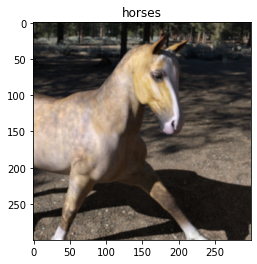

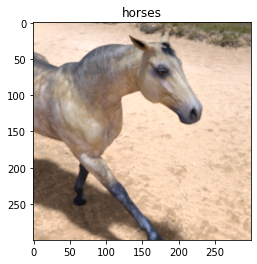

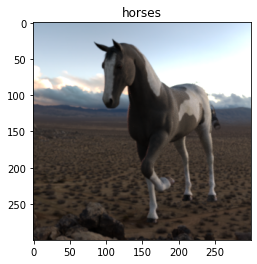

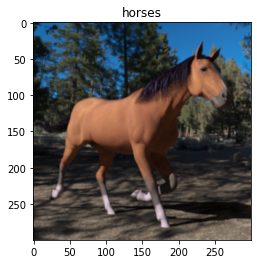

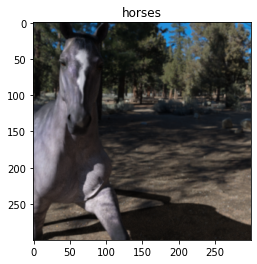

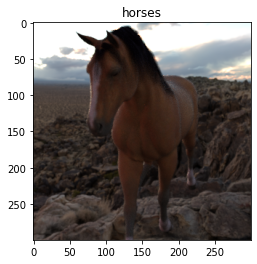

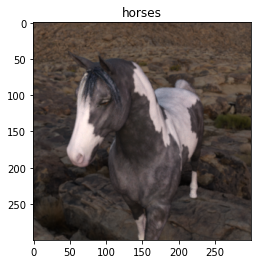

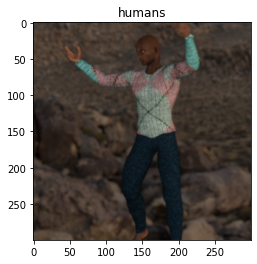

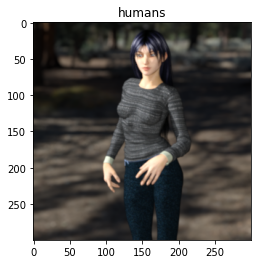

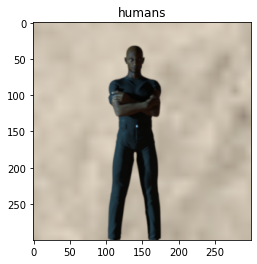

In [3]:
# checking out the data
get_label_name = metadata.features['label'].int2str

def show_images(dataset):
    for image, label in dataset.take(10):
        plt.figure()
        plt.imshow(image)
        plt.title(get_label_name(label))
        
show_images(raw_train)        

In [4]:
# resizing and normalizing the photos for mobilenetv2
img_size = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1 # normalization
    image = tf.image.resize(image, (img_size, img_size))
    return image, label

train = raw_train.map(format_example)
test = raw_test.map(format_example)    

In [5]:
# shuffling the training data and batching the training & test data
batch_size = 32
shuffle_buffer_size = 2000
train_batches = train.shuffle(shuffle_buffer_size).batch(batch_size)
test_batches = test.batch(batch_size)

In [6]:
# shaping the model, and implementing MobileNetV2 architecture for our classifier
img_shape = (img_size, img_size, 3) # 160, 160, 3
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights="imagenet")
base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
________________

In [7]:
# making sure the shape of the batch is correct, should be (32, 160, 160, 3)
for image_batch, label_batch in train_batches.take(1):
    pass
print(image_batch.shape)

(32, 160, 160, 3)


In [9]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# creating model

In [15]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])
# compiling model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss="binary_crossentropy", metrics=['accuracy'])